In [145]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm, tqdm_notebook
from pathlib import Path
# pd.set_option('display.max_columns', 1000)
# pd.set_option('display.max_rows', 400)
sns.set()

os.chdir('..')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
DATA = Path('data')
RAW  = DATA/'raw'
SUBMISSIONS = DATA/'submissions'

In [3]:
train      = pd.read_csv(RAW/'train_jqd04QH.csv', low_memory=False)
test       = pd.read_csv(RAW/'test_GYi4Gz5.csv', low_memory=False)
submission = pd.read_csv(RAW/'sample_submission_sxfcbdx.csv', low_memory=False)

In [4]:
id_col = 'enrollee_id'
cat_cols = ['city', 'gender', 'relevent_experience', 'enrolled_university', 
            'education_level', 'major_discipline', 'experience', 'company_size', 
            'company_type', 'last_new_job']
num_cols = ['city_development_index', 'training_hours']
target_col = 'target'

In [6]:
%%time
from src.utils import preprocess
preprocess(train, test, cat_cols, num_cols)

CPU times: user 84 ms, sys: 4 ms, total: 88 ms
Wall time: 86.6 ms


In [8]:
from sklearn.model_selection import StratifiedKFold
columns = list(train.drop([id_col, target_col], axis=1))
cat_indices = [i for i, col in enumerate(columns) if col in cat_cols]
kfolds = StratifiedKFold(n_splits=5, random_state=42)

In [24]:
val_results = pd.DataFrame()
tst_results = pd.DataFrame()

## Catboost

In [10]:
from src.oofpredictions import test_catboost
from catboost import CatBoostClassifier

In [28]:
%%time
y_test, y_pred = test_catboost(CatBoostClassifier(iterations=1000, 
                        random_seed=42, eval_metric='AUC', od_pval=1e-3,
                        depth=7),
                    train.drop([id_col, target_col], axis=1), 
                    train[target_col], test.drop(id_col, axis=1),
                    kfolds, cat_indices)

No. estimators: 489 | Train AUC: 71.69 | Val AUC: 68.96
No. estimators: 568 | Train AUC: 72.72 | Val AUC: 64.28
No. estimators: 366 | Train AUC: 71.03 | Val AUC: 66.64
No. estimators: 429 | Train AUC: 71.04 | Val AUC: 67.69
No. estimators: 409 | Train AUC: 71.93 | Val AUC: 68.16

Train AUC: 71.68 +/- 1.26 | Val AUC: 67.15 +/- 3.23

CPU times: user 13min 2s, sys: 1min 12s, total: 14min 15s
Wall time: 1min 48s


In [29]:
val_results['CatBoost'] = y_pred
tst_results['CatBoost'] = y_test

## XGBoost

In [18]:
from src.oofpredictions import test_xgb
import xgboost as xgb

In [21]:
%%time
y_test, y_pred = test_xgb(xgb,
                    train.drop([id_col, target_col], axis=1),
                    train[target_col], test.drop(id_col, axis=1), kfolds)

No. estimators: 15 | Train AUC: 68.32 | Val AUC: 68.00
No. estimators: 38 | Train AUC: 72.18 | Val AUC: 64.42
No. estimators: 16 | Train AUC: 69.48 | Val AUC: 66.02
No. estimators: 43 | Train AUC: 72.26 | Val AUC: 66.56
No. estimators: 13 | Train AUC: 68.08 | Val AUC: 67.74

Train AUC: 70.07 +/- 3.65 | Val AUC: 66.55 +/- 2.58

CPU times: user 5.16 s, sys: 8 ms, total: 5.17 s
Wall time: 1.09 s


In [25]:
val_results['XGB'] = y_pred
tst_results['XGB'] = y_test

## LightGBM

In [32]:
from src.oofpredictions import test_lgbm
import lightgbm as lgbm

In [34]:
%%time
y_test, y_pred = test_lgbm(lgbm,
                    train.drop([id_col, target_col], axis=1), 
                    train[target_col], test.drop(id_col, axis=1),
                    kfolds, cat_indices)

/home/raduviri/anaconda3/envs/chana/lib/python3.6/site-packages/lightgbm/basic.py:1038: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is [0, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/raduviri/anaconda3/envs/chana/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


No. estimators: 22 | Train AUC: 72.46 | Val AUC: 68.34
No. estimators: 11 | Train AUC: 70.87 | Val AUC: 64.65
No. estimators: 13 | Train AUC: 70.94 | Val AUC: 65.98
No. estimators: 12 | Train AUC: 71.34 | Val AUC: 66.63
No. estimators: 18 | Train AUC: 71.49 | Val AUC: 68.46

Train AUC: 71.42 +/- 1.14 | Val AUC: 66.81 +/- 2.89

CPU times: user 2.87 s, sys: 32 ms, total: 2.9 s
Wall time: 582 ms


In [35]:
val_results['LGBM'] = y_pred
tst_results['LGBM'] = y_test

## Random Forest

In [37]:
from src.oofpredictions import test_tree
from sklearn.ensemble import RandomForestClassifier

In [39]:
%%time
y_test, y_pred = test_tree(RandomForestClassifier(n_estimators=200, 
                        random_state=42, max_depth=7, n_jobs=-1),
                    train.drop([id_col, target_col], axis=1), 
                    train[target_col], test.drop(id_col, axis=1), kfolds)

Train AUC: 74.58 | Val AUC: 68.76
Train AUC: 75.43 | Val AUC: 64.34
Train AUC: 74.85 | Val AUC: 65.94
Train AUC: 74.81 | Val AUC: 67.64
Train AUC: 74.91 | Val AUC: 67.07

Train AUC: 74.91 +/- 0.56 | Val AUC: 66.75 +/- 3.02

CPU times: user 15.8 s, sys: 680 ms, total: 16.5 s
Wall time: 4.15 s


In [40]:
val_results['RF'] = y_pred
tst_results['RF'] = y_test

## Extra Trees

In [41]:
from sklearn.ensemble import ExtraTreesClassifier

In [42]:
%%time
y_test, y_pred = test_tree(ExtraTreesClassifier(n_estimators=400, 
                        random_state=42, max_depth=8, n_jobs=-1),
                    train.drop([id_col, target_col], axis=1), 
                    train[target_col], test.drop(id_col, axis=1), kfolds)

Train AUC: 75.66 | Val AUC: 67.67
Train AUC: 76.51 | Val AUC: 63.85
Train AUC: 75.89 | Val AUC: 65.28
Train AUC: 75.89 | Val AUC: 67.96
Train AUC: 76.21 | Val AUC: 66.82

Train AUC: 76.03 +/- 0.60 | Val AUC: 66.31 +/- 3.09

CPU times: user 23 s, sys: 1.06 s, total: 24 s
Wall time: 5.54 s


In [43]:
val_results['ET'] = y_pred
tst_results['ET'] = y_test

## Neural Net

In [46]:
from src.oofpredictions import test_neuralnet

In [47]:
%%time
USE_CUDA = True
y_test, y_pred = test_neuralnet(
                train.drop([id_col, target_col], axis=1), 
                train[target_col], test.drop(id_col, axis=1),
                kfolds, cat_cols, num_cols, USE_CUDA)

Epoch: 1 | Train AUC: 64.19 | Val AUC: 62.83
Epoch: 2 | Train AUC: 67.20 | Val AUC: 65.27
Epoch: 3 | Train AUC: 68.08 | Val AUC: 65.89
Epoch: 4 | Train AUC: 68.77 | Val AUC: 65.91
Epoch: 5 | Train AUC: 69.17 | Val AUC: 65.89
Epoch: 6 | Train AUC: 70.79 | Val AUC: 66.61
Epoch: 7 | Train AUC: 71.52 | Val AUC: 65.12
Best epoch: 6 | Train AUC: 70.79 | Val AUC: 66.61

Epoch: 1 | Train AUC: 66.10 | Val AUC: 61.15
Epoch: 2 | Train AUC: 68.66 | Val AUC: 62.84
Epoch: 3 | Train AUC: 69.54 | Val AUC: 63.39
Epoch: 4 | Train AUC: 69.22 | Val AUC: 63.12
Epoch: 5 | Train AUC: 71.00 | Val AUC: 62.71
Epoch: 6 | Train AUC: 71.21 | Val AUC: 63.33
Epoch: 7 | Train AUC: 72.06 | Val AUC: 63.42
Best epoch: 7 | Train AUC: 72.06 | Val AUC: 63.42

Epoch: 1 | Train AUC: 68.38 | Val AUC: 64.30
Epoch: 2 | Train AUC: 69.05 | Val AUC: 64.59
Epoch: 3 | Train AUC: 70.36 | Val AUC: 64.01
Epoch: 4 | Train AUC: 71.30 | Val AUC: 64.61
Epoch: 5 | Train AUC: 71.13 | Val AUC: 64.15
Epoch: 6 | Train AUC: 72.75 | Val AUC: 63.7

In [48]:
val_results['NeuralNet'] = y_pred
tst_results['NeuralNet'] = y_test

## Correlation

In [51]:
val_results.to_csv(SUBMISSIONS/'val_results.csv', index=False)
tst_results.to_csv(SUBMISSIONS/'tst_results.csv', index=False)

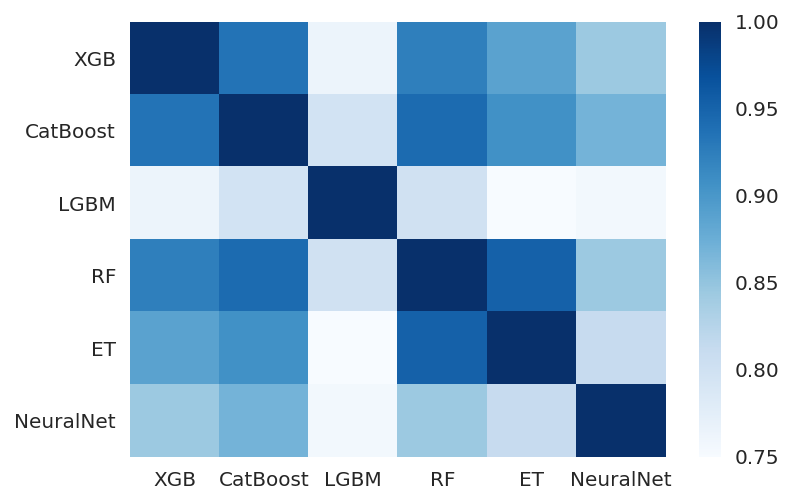

In [53]:
corr = val_results.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,
            cmap='Blues')

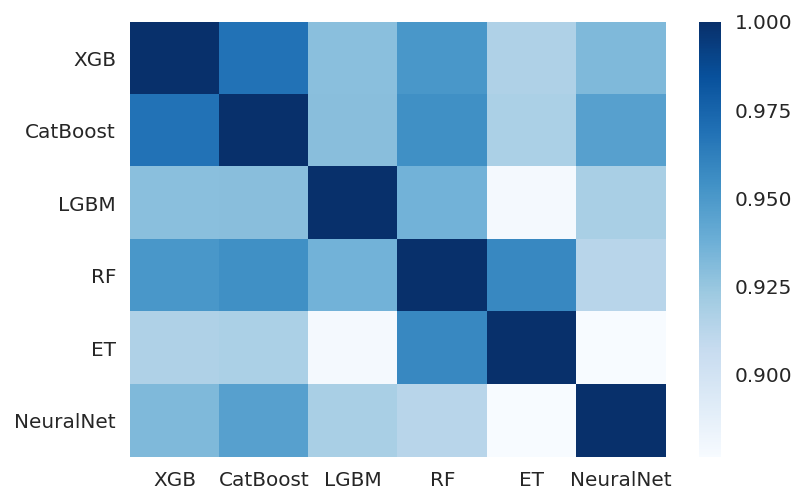

In [55]:
corr = tst_results.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,
            cmap='Blues')

## Stacking

In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from src.utils import eval_sklearn, print_results

In [91]:
%%time
# solver : {'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'},
trn_aucs, val_aucs = eval_tree(LogisticRegression(max_iter=1000, 
                    random_state=42, C=1),
                    val_results, train[target_col], kfolds)

Train AUC: 66.74 | Val AUC: 68.98
Train AUC: 67.81 | Val AUC: 64.71
Train AUC: 67.34 | Val AUC: 66.50
Train AUC: 67.11 | Val AUC: 67.63
Train AUC: 66.94 | Val AUC: 68.20

CPU times: user 476 ms, sys: 1.35 s, total: 1.82 s
Wall time: 189 ms


In [66]:
# C 1.0
print_results(trn_aucs, val_aucs)

Train AUC: 67.19 +/- 0.74 | Val AUC: 67.21 +/- 2.97


In [92]:
model = LogisticRegression(max_iter=1000, random_state=42, C=1)

In [93]:
model.fit(val_results, train[target_col])

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [94]:
y_test = model.predict_proba(tst_results)[:,1]

## Submission

In [95]:
test[target_col] = y_test

In [96]:
submission = pd.read_csv(RAW/'sample_submission_sxfcbdx.csv', low_memory=False)
submission = pd.merge(submission[[id_col]], test[[id_col, target_col]], how='left', on=id_col)

In [97]:
submission.head()

,enrollee_id,target
0,16548,0.618255
1,12036,0.080040
2,11061,0.369606
3,5032,0.083294
4,17599,0.094549


In [98]:
submission[target_col].describe()

count    15021.000000
mean         0.131810
std          0.072759
min          0.068903
25%          0.085128
50%          0.100317
75%          0.149672
max          0.701719
Name: target, dtype: float64

In [99]:
submission.to_csv(SUBMISSIONS/'12-stacking_6models.csv', index=False)

## Average models

In [105]:
test[target_col] = tst_results.mean(axis=1)

In [107]:
submission = pd.read_csv(RAW/'sample_submission_sxfcbdx.csv', low_memory=False)
submission = pd.merge(submission[[id_col]], test[[id_col, target_col]], how='left', on=id_col)

In [108]:
submission.head()

,enrollee_id,target
0,16548,0.452986
1,12036,0.088789
2,11061,0.321728
3,5032,0.093649
4,17599,0.109467


In [109]:
submission[target_col].describe()

count    15021.000000
mean         0.144819
std          0.063184
min          0.070761
25%          0.097724
50%          0.119681
75%          0.175169
max          0.488227
Name: target, dtype: float64

In [110]:
submission.to_csv(SUBMISSIONS/'13-average_6models.csv', index=False)

## Output each model

In [112]:
tst_results.columns

Index(['XGB', 'CatBoost', 'LGBM', 'RF', 'ET', 'NeuralNet'], dtype='object')

In [113]:
test[target_col] = tst_results.XGB
submission = pd.read_csv(RAW/'sample_submission_sxfcbdx.csv', low_memory=False)
submission = pd.merge(submission[[id_col]], test[[id_col, target_col]], how='left', on=id_col)
submission.to_csv(SUBMISSIONS/'14-XGBoost.csv', index=False)

In [114]:
test[target_col] = tst_results.CatBoost
submission = pd.read_csv(RAW/'sample_submission_sxfcbdx.csv', low_memory=False)
submission = pd.merge(submission[[id_col]], test[[id_col, target_col]], how='left', on=id_col)
submission.to_csv(SUBMISSIONS/'15-CatBoost.csv', index=False)

In [115]:
test[target_col] = tst_results.LGBM
submission = pd.read_csv(RAW/'sample_submission_sxfcbdx.csv', low_memory=False)
submission = pd.merge(submission[[id_col]], test[[id_col, target_col]], how='left', on=id_col)
submission.to_csv(SUBMISSIONS/'16-LGBM.csv', index=False)

In [116]:
test[target_col] = tst_results.RF
submission = pd.read_csv(RAW/'sample_submission_sxfcbdx.csv', low_memory=False)
submission = pd.merge(submission[[id_col]], test[[id_col, target_col]], how='left', on=id_col)
submission.to_csv(SUBMISSIONS/'17-RandomForest.csv', index=False)

In [117]:
test[target_col] = tst_results.ET
submission = pd.read_csv(RAW/'sample_submission_sxfcbdx.csv', low_memory=False)
submission = pd.merge(submission[[id_col]], test[[id_col, target_col]], how='left', on=id_col)
submission.to_csv(SUBMISSIONS/'18-ExtraTrees.csv', index=False)

In [118]:
test[target_col] = tst_results.NeuralNet
submission = pd.read_csv(RAW/'sample_submission_sxfcbdx.csv', low_memory=False)
submission = pd.merge(submission[[id_col]], test[[id_col, target_col]], how='left', on=id_col)
submission.to_csv(SUBMISSIONS/'19-NeuralNet.csv', index=False)

## Use previous Neural Net

In [120]:
df = tst_results.copy()

In [121]:
neuralnet = pd.read_csv(SUBMISSIONS/'07-neuralnet_labelordinal_alldata.csv')

In [123]:
df['NeuralNet'] = neuralnet.target

In [124]:
tst_results.head()

,XGB,CatBoost,LGBM,RF,ET,NeuralNet
0,0.504289,0.509852,0.397736,0.377069,0.403736,0.525236
1,0.072444,0.073249,0.176390,0.072624,0.083126,0.054900
2,0.338680,0.409235,0.321829,0.293620,0.259924,0.307078
3,0.082260,0.077036,0.179196,0.086243,0.086747,0.050409
4,0.096533,0.091999,0.190101,0.102696,0.118816,0.056658


In [132]:
df.head()

,XGB,CatBoost,LGBM,RF,ET,NeuralNet
0,0.504289,0.509852,0.397736,0.377069,0.403736,0.367501
1,0.072444,0.073249,0.176390,0.072624,0.083126,0.055319
2,0.338680,0.409235,0.321829,0.293620,0.259924,0.335810
3,0.082260,0.077036,0.179196,0.086243,0.086747,0.058766
4,0.096533,0.091999,0.190101,0.102696,0.118816,0.074805


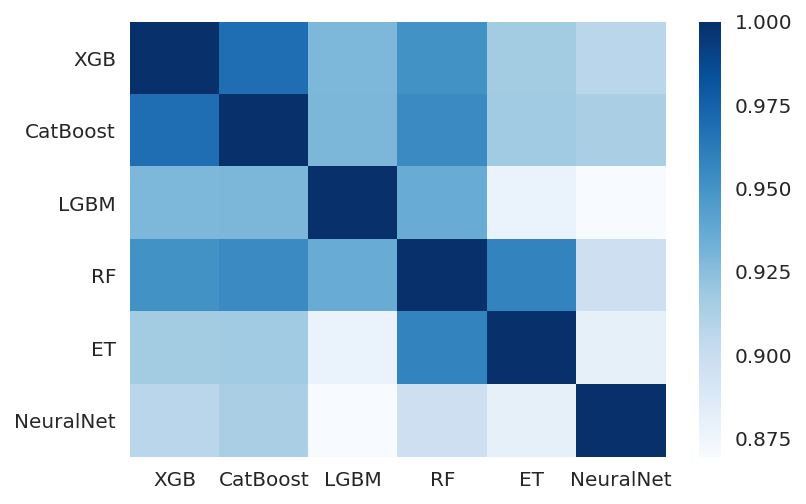

In [125]:
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,
            cmap='Blues')

In [127]:
y_test = model.predict_proba(df)[:,1]

In [128]:
test[target_col] = y_test
submission = pd.read_csv(RAW/'sample_submission_sxfcbdx.csv', low_memory=False)
submission = pd.merge(submission[[id_col]], test[[id_col, target_col]], how='left', on=id_col)
submission.to_csv(SUBMISSIONS/'20-NewNN_stacking.csv', index=False)

In [130]:
submission.target.describe()

count    15021.000000
mean         0.131552
std          0.073305
min          0.067752
25%          0.084774
50%          0.099908
75%          0.149280
max          0.698359
Name: target, dtype: float64

In [131]:
test[target_col] = df.mean(axis=1)
submission = pd.read_csv(RAW/'sample_submission_sxfcbdx.csv', low_memory=False)
submission = pd.merge(submission[[id_col]], test[[id_col, target_col]], how='left', on=id_col)
submission.to_csv(SUBMISSIONS/'21-NewNN_average.csv', index=False)

## Use previous Catboost

In [162]:
df = tst_results.copy()
neuralnet = pd.read_csv(SUBMISSIONS/'07-neuralnet_labelordinal_alldata.csv')
catboost = pd.read_csv(SUBMISSIONS/'06-catboost_labelordinal_alldata.csv')

In [163]:
df['NeuralNet'] = neuralnet.target
df['CatBoost'] = catboost.target

In [159]:
df.head()

,XGB,CatBoost,LGBM,RF,ET,NeuralNet
0,0.504289,0.509852,0.397736,0.377069,0.403736,0.367501
1,0.072444,0.073249,0.176390,0.072624,0.083126,0.055319
2,0.338680,0.409235,0.321829,0.293620,0.259924,0.335810
3,0.082260,0.077036,0.179196,0.086243,0.086747,0.058766
4,0.096533,0.091999,0.190101,0.102696,0.118816,0.074805


In [139]:
df.head()

,XGB,CatBoost,LGBM,RF,ET,NeuralNet
0,0.504289,0.558407,0.397736,0.377069,0.403736,0.367501
1,0.072444,0.063185,0.176390,0.072624,0.083126,0.055319
2,0.338680,0.471543,0.321829,0.293620,0.259924,0.335810
3,0.082260,0.083252,0.179196,0.086243,0.086747,0.058766
4,0.096533,0.148626,0.190101,0.102696,0.118816,0.074805


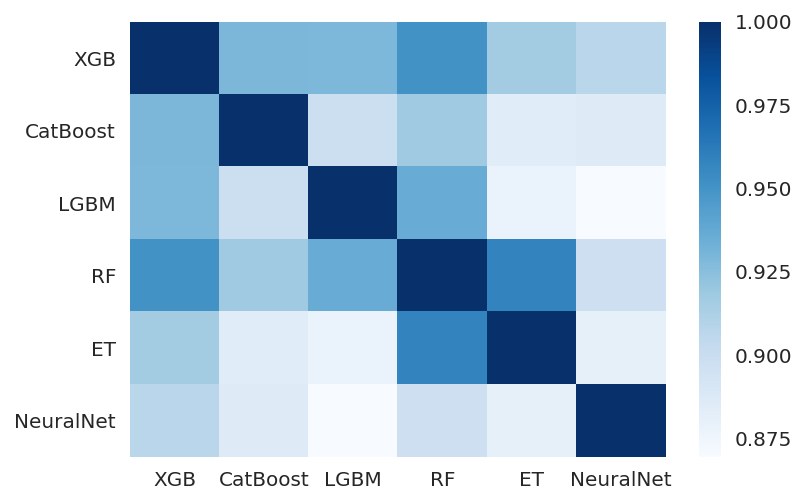

In [140]:
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,
            cmap='Blues')

In [141]:
y_test = model.predict_proba(df)[:,1]

In [142]:
test[target_col] = y_test
submission = pd.read_csv(RAW/'sample_submission_sxfcbdx.csv', low_memory=False)
submission = pd.merge(submission[[id_col]], test[[id_col, target_col]], how='left', on=id_col)
submission.to_csv(SUBMISSIONS/'22-NewNNCB_stacking.csv', index=False)

In [143]:
test[target_col] = df.mean(axis=1)
submission = pd.read_csv(RAW/'sample_submission_sxfcbdx.csv', low_memory=False)
submission = pd.merge(submission[[id_col]], test[[id_col, target_col]], how='left', on=id_col)
submission.to_csv(SUBMISSIONS/'23-NewNNCB_average.csv', index=False)

## Filter 

In [ ]:
# NeuralNet, ExtraTrees, LGBM, CatBoost

In [146]:
df.head()

,XGB,CatBoost,LGBM,RF,ET,NeuralNet
0,0.504289,0.558407,0.397736,0.377069,0.403736,0.367501
1,0.072444,0.063185,0.176390,0.072624,0.083126,0.055319
2,0.338680,0.471543,0.321829,0.293620,0.259924,0.335810
3,0.082260,0.083252,0.179196,0.086243,0.086747,0.058766
4,0.096533,0.148626,0.190101,0.102696,0.118816,0.074805


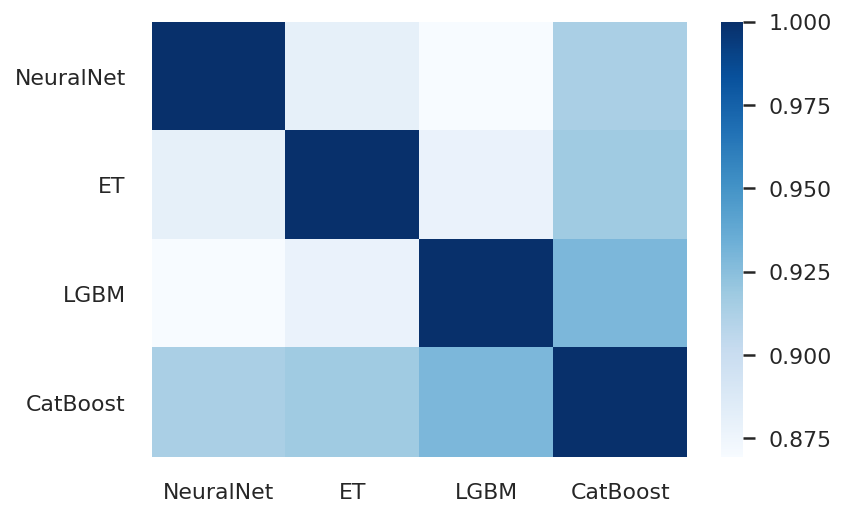

In [160]:
corr = df[['NeuralNet', 'ET', 'LGBM', 'CatBoost']].corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,
            cmap='Blues')

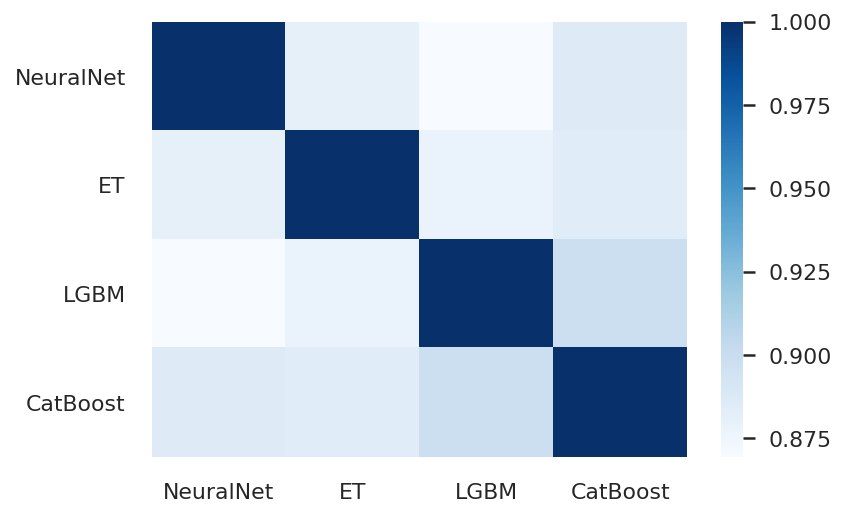

In [147]:
corr = df[['NeuralNet', 'ET', 'LGBM', 'CatBoost']].corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,
            cmap='Blues')

In [148]:
%%time
trn_aucs, val_aucs = eval_tree(LogisticRegression(max_iter=1000, 
                    random_state=42, C=1),
                    val_results[['NeuralNet', 'ET', 'LGBM', 'CatBoost']], train[target_col], kfolds)

Train AUC: 66.70 | Val AUC: 68.88
Train AUC: 67.77 | Val AUC: 64.65
Train AUC: 67.28 | Val AUC: 66.52
Train AUC: 67.01 | Val AUC: 67.67
Train AUC: 66.88 | Val AUC: 68.23

CPU times: user 588 ms, sys: 1.34 s, total: 1.93 s
Wall time: 205 ms


In [149]:
# C 1.0
print_results(trn_aucs, val_aucs)

Train AUC: 67.13 +/- 0.74 | Val AUC: 67.19 +/- 2.97


In [150]:
test[target_col] = df[['NeuralNet', 'ET', 'LGBM', 'CatBoost']].mean(axis=1)
submission = pd.read_csv(RAW/'sample_submission_sxfcbdx.csv', low_memory=False)
submission = pd.merge(submission[[id_col]], test[[id_col, target_col]], how='left', on=id_col)
submission.to_csv(SUBMISSIONS/'25-NN_ET_LGBM_CB_average.csv', index=False)

In [ ]:
# LGBM: 0.684706022089883
# ET  : 0.68113893932674
# CB  : 0.680416298649361
# NN  : 0.684812668134945

In [156]:
test[target_col] = df[['NeuralNet', 'ET', 'LGBM', 'CatBoost']].mean(axis=1)
submission = pd.read_csv(RAW/'sample_submission_sxfcbdx.csv', low_memory=False)
submission = pd.merge(submission[[id_col]], test[[id_col, target_col]], how='left', on=id_col)
submission.to_csv(SUBMISSIONS/'26-NN_ET_LGBM_05CB_average.csv', index=False)

In [161]:
test[target_col] = df[['NeuralNet', 'ET', 'LGBM', 'CatBoost']].mean(axis=1)
submission = pd.read_csv(RAW/'sample_submission_sxfcbdx.csv', low_memory=False)
submission = pd.merge(submission[[id_col]], test[[id_col, target_col]], how='left', on=id_col)
submission.to_csv(SUBMISSIONS/'27-NN_ET_LGBM_15CB_average.csv', index=False)

In [165]:
test[target_col] = df[['NeuralNet', 'LGBM']].mean(axis=1)
submission = pd.read_csv(RAW/'sample_submission_sxfcbdx.csv', low_memory=False)
submission = pd.merge(submission[[id_col]], test[[id_col, target_col]], how='left', on=id_col)
submission.to_csv(SUBMISSIONS/'28-NN_LGBM_average.csv', index=False)